## 프로젝트 : CAM을 만들고 평가해보자

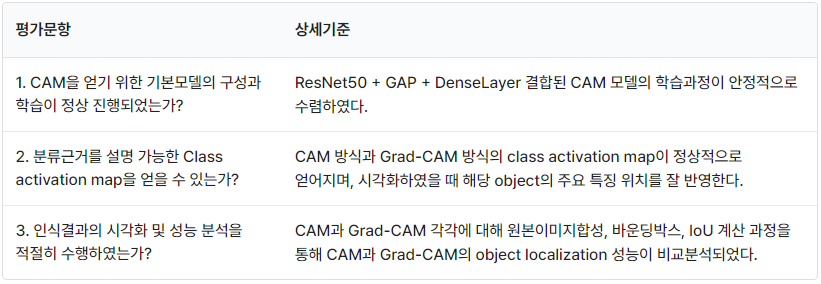

라이브러리 로드

In [1]:
# module import
import os
import copy
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50 
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image

데이터셋로드<br>
shuffile_files = True로 하지 않을 Train이 정상적으로 안될 수 있음

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,       
)

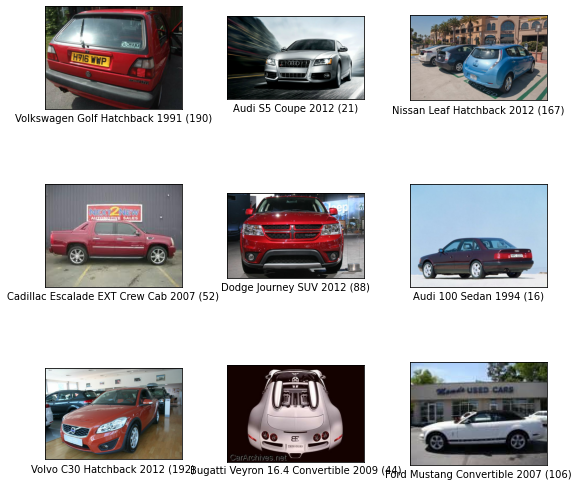

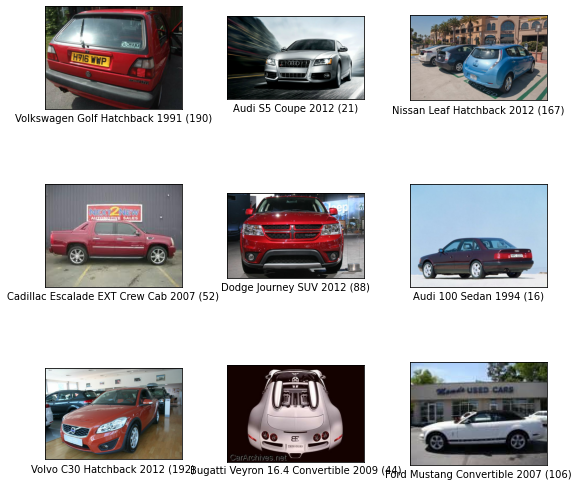

In [3]:
tfds.show_examples(ds_train, ds_info)

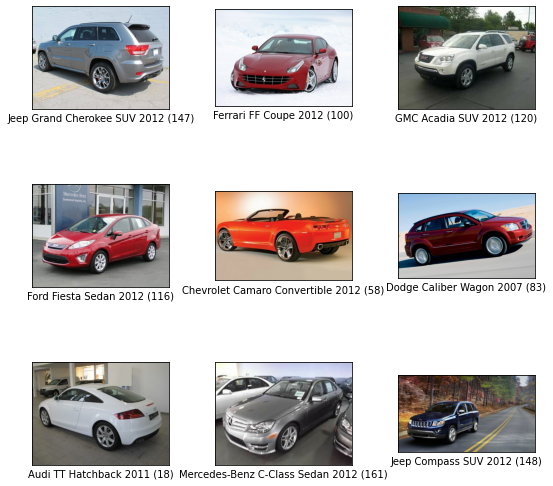

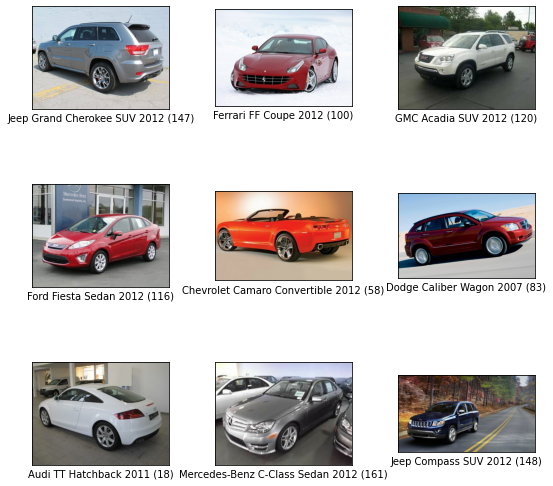

In [4]:
tfds.show_examples(ds_test, ds_info)

데이터 정보 확인

In [5]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

모델 구성
<br>
- 기본 keras에서 지원하는 ResNet50모델에서 GAP을 적용하고 fine_tunning부분을 추가하여 모델을 구성함

In [6]:
num_classes = ds_info.features['label'].num_classes
base_model = ResNet50(
    include_top=False,  #FC 생성 제외
    weights = 'imagenet',
    input_shape=(224,224,3),
    pooling='avg', # GAP적용 
)
x = base_model.output
preds = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = tf.keras.Model(inputs=base_model.input, outputs=preds)


In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
def normalize_and_resize_image(input):
    image = tf.image.resize(input['image'],[224,224])
    input['image'] = tf.cast(image, tf.float32)/255.
    
    return input['image'], input['label']

In [9]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_image,
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [11]:
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


하이퍼 파라미터 및 옵티마이저 설정

In [12]:
tf.random.set_seed(42)

cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
    metrics=['accuracy'],
)

In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16 ),
    validation_steps=int(ds_info.splits['test'].num_examples / 16 ),
    epochs=15,
    validation_data = ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 129s 229ms/step - loss: 3.8827 - accuracy: 0.1709 - val_loss: 5.5688 - val_accuracy: 0.0276
Epoch 2/15
509/509 [==============================] - 117s 229ms/step - loss: 1.5709 - accuracy: 0.5785 - val_loss: 2.5713 - val_accuracy: 0.3870
Epoch 3/15
509/509 [==============================] - 116s 227ms/step - loss: 0.6402 - accuracy: 0.8175 - val_loss: 2.0676 - val_accuracy: 0.5026
Epoch 4/15
509/509 [==============================] - 116s 227ms/step - loss: 0.2043 - accuracy: 0.9468 - val_loss: 1.1285 - val_accuracy: 0.7136
Epoch 5/15
509/509 [==============================] - 115s 227ms/step - loss: 0.0590 - accuracy: 0.9880 - val_loss: 0.9575 - val_accuracy: 0.7519
Epoch 6/15
509/509 [==============================] - 116s 227ms/step - loss: 0.0232 - accuracy: 0.9958 - val_loss: 0.8679 - val_accuracy: 0.7774
Epoch 7/15
509/509 [==============================] - 116s 227ms/step - loss: 0.0091 - accuracy: 0.9978 - val_loss: 0.7989 -

In [14]:
cam_model_path = 'cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


저장 완료!


In [15]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    return sample_data[0]

141


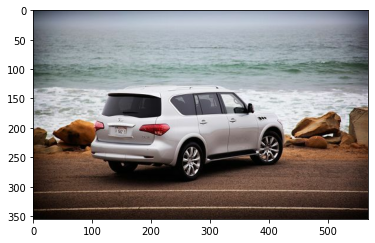

In [17]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
    

CAM 구현

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_image(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = tf.squeeze(conv_outputs, axis=0)
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:,:, i]
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    
    return cam_image

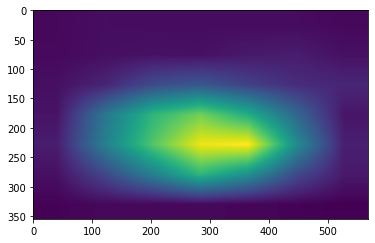

In [19]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [20]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

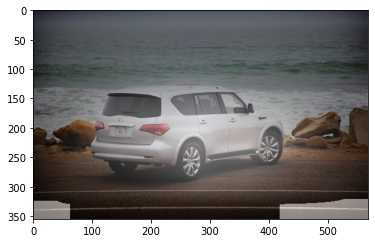

In [22]:
cam_blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(cam_blended_image)

Grad-CAM

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_image(item)
    
    grad_model = tf.keras.models.Model([model.input], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, axis=0))
        
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]
        
    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

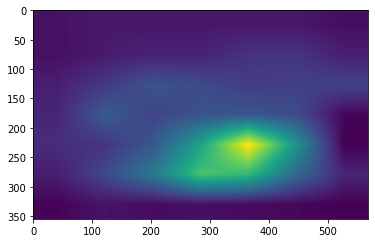

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

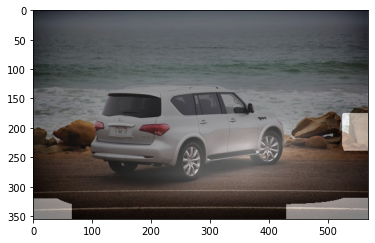

In [25]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_blended_image)

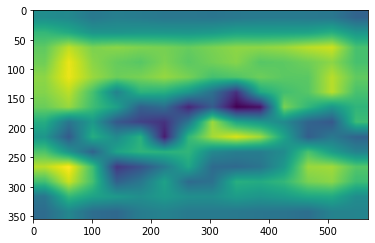

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

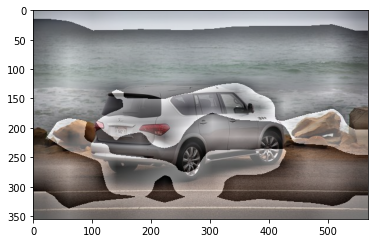

In [27]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

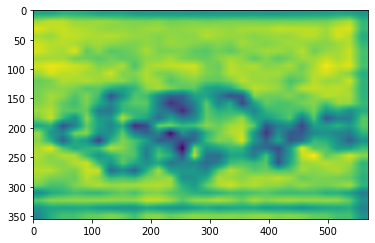

In [28]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

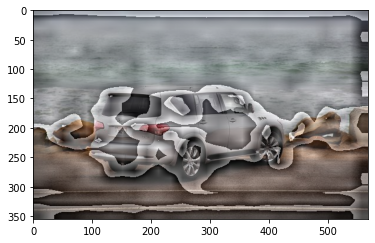

In [29]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

Bounding Box

In [30]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [31]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[-12,  98],
       [564,  50],
       [585, 306],
       [  8, 353]])

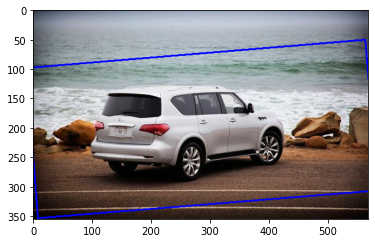

In [32]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

IoUI

In [33]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [34]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.14084507042253522,
 -0.0210896309314587,
 0.9943661971830986,
 1.0281195079086116]

In [35]:
item['bbox']

array([0.35211268, 0.16695958, 0.8197183 , 0.7557118 ], dtype=float32)

In [36]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [37]:
get_iou(pred_bbox, item['bbox']) # 0.7401634900323132

0.307422698141492

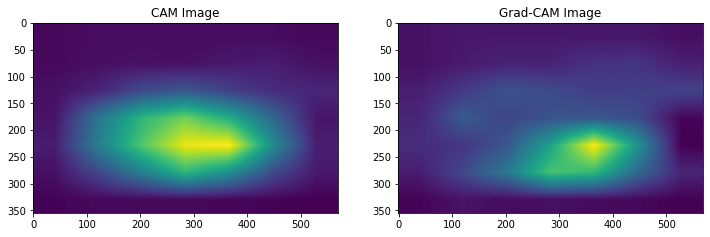

In [38]:
cam_image = generate_cam(cam_model, item)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_cam_image)

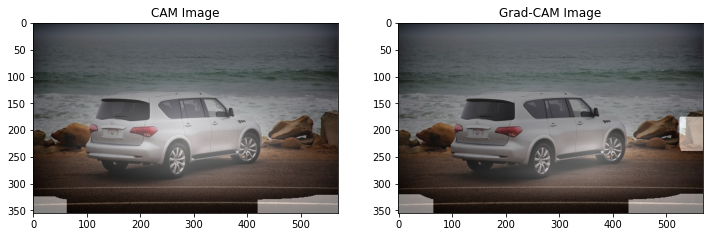

In [39]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

cam_blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_blended_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_blended_image)

In [40]:
cam_rect = get_bbox(cam_image)
grad_cam_rect = get_bbox(grad_cam_image)

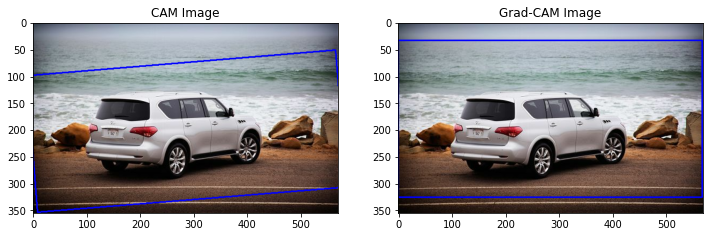

In [41]:
cam_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [cam_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [grad_cam_rect], 0, (0, 0, 255), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_bbox_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_cam_bbox_image)

In [42]:
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])

In [43]:
cam_iou = get_iou(cam_pred_bbox, item['bbox'])
grad_cam_iou = get_iou(grad_cam_pred_bbox, item['bbox'])

In [44]:
print(f'CAM IoU : {cam_iou}')
print(f'Grad-CAM IoU : {grad_cam_iou}')

CAM IoU : 0.307422698141492
Grad-CAM IoU : 0.33473583671628193


In [45]:
y1 = int(item['image'].shape[0] * item['bbox'][0])
y2 = int(item['image'].shape[0] * item['bbox'][2])
x1 = int(item['image'].shape[1] * item['bbox'][1])
x2 = int(item['image'].shape[1] * item['bbox'][3])
orig_rect = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])

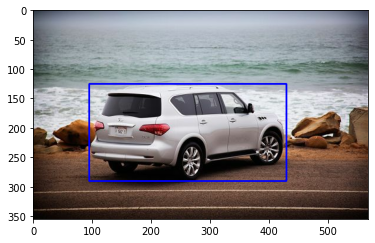

In [46]:
orig_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [orig_rect], 0, (0, 0, 255), 2)
plt.imshow(orig_bbox_image)

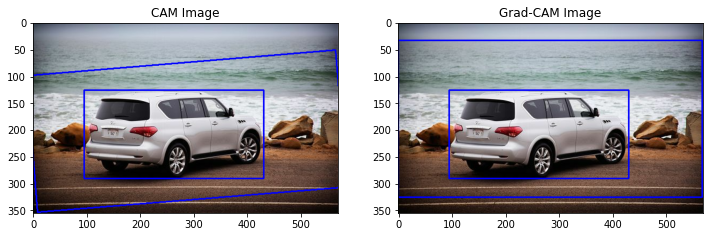

In [47]:
cam_bbox_image = cv2.drawContours(cam_bbox_image, [orig_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_image = cv2.drawContours(grad_cam_bbox_image, [orig_rect], 0, (0, 0, 255), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_bbox_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_cam_bbox_image)

## 회고
<br>
- CAM과 Grad-CAM에서 이미지의 bbox를 찾는 과정을 기존과 다른 방식으로 도출하는 과정을 알게 됨<br>
- 모델의 수행과정을 시각화하는 과정에서 찾아낸 특징을 기준으로 보간(Interpolation)을 통해서 원본 이미지 크기로 확대하여<br>
  이미지의 핵심 지역외 이미지와 관련있는 부분을 찾아내고 OpenCV의 툴을 통해서 bounding box를 찾아내는 과정으로 이해했음<br>
  추후 동일 과정을 반복시 위에 기술과정과 비교하면 많은 도움이 될것 같음<br>
- CAM은 출력층 이전에만 해당되지만 Grad-CAM은 특정 층에 관계없이 해당 층에서 도출이 가능함<br>
- Grad-CAM이 CAM보다 IoU가 더 높게 나옴<br>
  CAM IoU : 0.307422698141492<br>
  Grad-CAM IoU : 0.33473583671628193<br><br>
  